# Can a better regional economy increase the ammount of available properties in AirBnb?
<img src= "resources/airbnb-2.jpg" width="700">
<b>Credit</b> <a href='https://www.thestreet.com/.image/t_share/MTc3MjA5Mjc2MzU0Mjc1MDY1/airbnb-2.jpg'>thestreet<a/>

## Introduction

**Business Context.** Airbnb is a community marketplace used to publish, advertise, and book accommodation in more than 190 countries via the internet or from your smartphone. It is based on the "Bed and Breakfast" mode (where the "bnb" comes from). It is one of the most successful systems of the collaborative economy, allowing the user to find accommodation, with the difference that it will not be in a hotel but in the house of a person who may even be living in it. The interesting thing is that you can rent from common apartments to tree houses, igloos, geo domes, mills, etc.      

Several studies have verified and quantified positive impacts on the region's economy with the arrival of Airbnb. However, if the inverse relationship is analyzed, would there be relationships between the region's economic situation and the price dynamics and number of reservations of its Airbnbs? Analyzing this type of relationship is relevant both because of the current economic situation that the world is experiencing with the appearance of the COVID-19 virus and because of the differentiated strategies that can be implemented by region according to their economic situation in the post-pandemic.

**Analytical Context.** To perform the analysis, the following data sets were selected:

   1. **listings:** Descriptive information on tens of thousands of Airbnb listings
   2. **unemployment_rate:** unemployment rate in USA classified by state
   3. **gdp:** gdp in USA classified by state


## Gathering Data

The activities carried out to obtain the data are described below.

### Airbnb data

We extracts available historical listing and calendar information for all US states from [Airbnb's website](http://insideairbnb.com/get-the-data.html) through a web scraping code:

```python
#Set the URL to webscraping
url = 'http://insideairbnb.com/get-the-data.html'
# Connect to the URL
response = requests.get(url)
# Parse HTML and save to BeautifulSoup object¶
soup = BeautifulSoup(response.text, 'html.parser')

# Loop to download the whole data set through all a tags 
typefile = ['calendar.csv.gz','listings.csv.gz']
for tag in soup.findAll('a'):  #'a' tags are for links
    try:
        link = tag['href']
        if link.find('united-states') > 1 and any(x in link for x in typefile):
            # download data with name format city_data_type.csv.gz
            urllib.request.urlretrieve(link,'lodging/datasets/usa/'+link.split('/')[5]+'_'+\
                                   link.split('/')[6]+'_'+link.split('/')[8]) 
            # pause the code for 3 sec to cheat possible "spam" and avoid connection interruptions by the website owner
            time.sleep(3) 
    except KeyError:
        pass 
    except requests.HTTPError as e:
        if e.response.status_code == 404:
            pass
```

**Note:** Quick inspection of the files revealed that information contained within the `calendar` files is already present in the `listings` files, so we will not use it.

### Pre processing

We need to read and attach multiple data from `listings` files. To facilitate the process, we select the columns that we believe can provide useful information within the analysis. To do this, we preview the data structure:

The selected columns are:

```python
select_cols = ['id','last_scraped','host_id','host_since','host_is_superhost','state','latitude','longitude',\
               'property_type','room_type','accommodates','bathrooms','bedrooms','beds','price','minimum_nights',\
               'availability_90','instant_bookable','cancellation_policy']
```

Once the columns are selected, a for loop is created to read and append all the US `listings` files by state.

```python
# Cities with same window time
cities = ['asheville','austin','boston','chicago','denver','los-angeles','nashville','new-orleans','new-york-city',\
                 'portland','twin-cities','washington']

# Directory with downloaded listings files
directory = os.listdir('lodging/datasets/usa/')   

# Loop for to read and create new consolidated listings file by city
for city in cities:
    df_listings = pd.DataFrame()
    city_files = [file for file in directory if file.startswith(city)] # filter directory by city
    print('-- Reading files of',city,'--')
    for filename in city_files:
        file_directory = os.path.join('lodging/datasets/usa/', filename)
        df = pd.read_csv(file_directory, compression = 'gzip', error_bad_lines = False)
        warnings.simplefilter("ignore") # to ignore the warnings message
        df = df[select_cols]
        df_listings = pd.concat([df_listings,df], ignore_index = True)
    print('Creating consolidated file')
    df_listings.to_csv('lodging/datasets/usa/append/'+ city + '_listings.csv', index = False)
    print('-- ',city,'file is ready --')
    print()
    
```

**Note:** The downloaded files were analyzed and selected to guaranteeing the same information window. The time window selected was _April 2018 - Jun 2020_. The city-states that have information within this time window are:

- **Asheville**, North Carolina
- **Austin**, Texas
- **Boston**, Massachusetts
- **Chicago**, Illinois
- **Denver**, Colorado
- **Los Angeles**, California
- **Nashville**, Tennessee
- **New Orleans**, Louisiana
- **New York City**, New York
- **Portland**, Oregon
- **Twin Cities MSA**, Minnesota
- **Washington D.C.**, District of Columbia

In the other side, all the macro-economic data was downloaded from official websites from USA. Then, data was cleaned, modified and structured to match it with the listing data structure. Below the links:

**Unemployment rate by state** https://beta.bls.gov/dataViewer/view/a053dd0d4632464bbdb51b05dc295ec2 https://beta.bls.gov/dataViewer/view/eda813873cac4da4be800035a2b9e355 Data extracted on: Dec 1, 2020 (10:22:36 AM) 
Local Area Unemployment Statistics Measure Data Type : unemployment rate Survey Name : Local Area Unemployment Statistics https://beta.bls.gov/dataQuery/find?q=unemployment+rate+

**Personal income and GDP** https://apps.bea.gov/regional/downloadzip.cfm

### Airbnb Data Cleaning

In [1]:
# libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sm2
import timeit
import warnings

from scipy import stats
from sklearn import preprocessing
from tqdm import tqdm

warnings.simplefilter('ignore')

In [2]:
# Loading data
consolidado_1 = pd.read_csv('data/debug_df_fix.csv')
consolidado_2 = pd.read_csv('data/debug_df_var.csv')
#import economic data
ur_dataframe = pd.read_csv('data/unemployment_rate_dataframe.csv')
gdp_dataframe = pd.read_csv('data/gdp_monthly_dataframe.csv')
pincome_dataframe = pd.read_csv('data/persona_income_monthly_dataframe.csv')

###### Processing listings

In [3]:
#Merging listings and state
consolidado = pd.merge(consolidado_2,consolidado_1, how="left", left_on='id', right_on='id' )

In [4]:
consolidado.columns

Index(['Unnamed: 0_x', 'id', 'price', 'minimum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365', 'quarter',
       'Unnamed: 0_y', 'host_id', 'host_since', 'host_is_superhost', 'city',
       'state', 'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'instant_bookable', 'cancellation_policy'],
      dtype='object')

In [5]:
consolidad_copy = consolidado.copy()
consolidad_copy.columns

Index(['Unnamed: 0_x', 'id', 'price', 'minimum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365', 'quarter',
       'Unnamed: 0_y', 'host_id', 'host_since', 'host_is_superhost', 'city',
       'state', 'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'instant_bookable', 'cancellation_policy'],
      dtype='object')

In [6]:
#Filtering by needed columns
consolidad_new = consolidad_copy[['id','quarter','property_type','state','price','accommodates', 'bathrooms', 'bedrooms','beds','availability_30','availability_60', 'availability_90', 'availability_365']]
print(consolidad_new['state'].unique())
print(consolidad_new.head(3))

['NY' 'OR' 'CA' 'CO' 'DC' 'TX' 'NC' 'IL' 'LA' 'TN' 'MN' 'MA' nan 'WI' 'MD'
 ' ' 'Allston, Ma' 'Sc' 'NJ' 'Beverly Hills' 'Dc' 'Tn' 'Ca' '加洲' '加州' 'Il'
 'ny' 'Manhattan' 'MP' 'ca']
       id  quarter property_type state   price  accommodates  bathrooms  \
0  100002  2Q-2018     Apartment    NY  $67.00           2.0        1.0   
1  100002  2Q-2018     Apartment    NY  $67.00           2.0        1.0   
2  100002  2Q-2018     Apartment    NY  $67.00           2.0        1.0   

   bedrooms  beds  availability_30  availability_60  availability_90  \
0       1.0   1.0               11               17               47   
1       1.0   1.0                3               25               43   
2       1.0   1.0                6               15               21   

   availability_365  
0               296  
1               304  
2               279  


In [7]:
#preparing data by state and returns array of dataframes
states_to_analyze = ['CA','LA','MN','OR','TN','NY','CO','MA','DC','TX','NC','IL']

def prepare_table( state_date_frame ):
    state_date_frame['price_clean'] = state_date_frame['price'].str[1:].str.replace(',','').astype('float')
    filtered_temp = state_date_frame[state_date_frame['price_clean']>0]
    filtered_temp.drop('price',axis=1,inplace=True)
    #array1= ['availability_30','availability_60','availability_90','availability_365']
    filtered_temp['price_normalized'] = (filtered_temp['price_clean']-filtered_temp['price_clean'].mean())/filtered_temp['price_clean'].std()
    filtered_temp['price_log'] = np.log(filtered_temp['price_clean'])
    return filtered_temp

#filtered.nunique(axis=0)

by_state_array = [prepare_table(consolidad_new[consolidad_new['state']==state]) for state in states_to_analyze]

In [8]:
by_state_array

[               id  quarter property_type state  accommodates  bathrooms  \
 51       10000255  3Q-2018   Condominium    CA           1.0        1.0   
 52       10000255  3Q-2018   Condominium    CA           1.0        1.0   
 53       10000255  4Q-2018   Condominium    CA           1.0        1.0   
 54       10000255  4Q-2018   Condominium    CA           1.0        1.0   
 55       10000255  4Q-2018   Condominium    CA           1.0        1.0   
 ...           ...      ...           ...   ...           ...        ...   
 2179051   9999011  3Q-2019     Townhouse    CA           2.0        1.0   
 2179052   9999011  3Q-2019     Townhouse    CA           2.0        1.0   
 2179053   9999011  4Q-2019     Townhouse    CA           2.0        1.0   
 2179054   9999011  4Q-2019     Townhouse    CA           2.0        1.0   
 2179055   9999011  4Q-2019     Townhouse    CA           2.0        1.0   
 
          bedrooms  beds  availability_30  availability_60  availability_90  \
 51    

In [9]:
#Stacking all dataframes 
#This new Data frame includes all information monthly for every selected state

full_df = pd.concat(by_state_array, axis=0, join='outer', verify_integrity=False, copy=True)
full_df.sort_values(by='quarter', inplace=True)  
full_df = full_df.reset_index(drop=True)

full_df

,id,quarter,property_type,state,accommodates,bathrooms,bedrooms,beds,availability_30,availability_60,availability_90,availability_365,price_clean,price_normalized,price_log
0,23791827,1Q-2019,Apartment,MA,2.0,1.0,1.0,1.0,30,54,70,345,65.0,-0.682972,4.174387
1,6290172,1Q-2019,Apartment,CA,1.0,1.0,1.0,1.0,0,0,0,0,33.0,-0.352935,3.496508
2,2634963,1Q-2019,Apartment,NY,5.0,1.5,3.0,3.0,0,0,0,249,290.0,0.656845,5.669881
3,24846589,1Q-2019,Townhouse,DC,7.0,2.0,3.0,3.0,23,52,77,251,230.0,0.048020,5.438079
4,24846589,1Q-2019,Townhouse,DC,7.0,2.0,3.0,3.0,22,48,73,247,230.0,0.048020,5.438079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171055,19316517,4Q-2019,Apartment,NY,2.0,1.0,1.0,1.0,0,0,0,0,90.0,-0.245397,4.499810
2171056,15324708,4Q-2019,Apartment,OR,5.0,1.0,1.0,3.0,1,23,53,76,105.0,-0.052620,4.653960
2171057,15324708,4Q-2019,Apartment,OR,5.0,1.0,1.0,3.0,19,40,64,64,105.0,-0.052620,4.653960
2171058,9822738,4Q-2019,Apartment,NY,4.0,1.0,1.0,2.0,0,0,0,0,199.0,0.246325,5.293305


In [10]:
full_df['state'].unique()

array(['MA', 'CA', 'NY', 'DC', 'TX', 'LA', 'TN', 'OR', 'MN', 'CO', 'IL',
       'NC'], dtype=object)

In [11]:
full_df.describe().round()

,id,accommodates,bathrooms,bedrooms,beds,availability_30,availability_60,availability_90,availability_365,price_clean,price_normalized,price_log
count,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0,2171060.0
mean,14863676.0,4.0,1.0,1.0,2.0,9.0,22.0,36.0,136.0,207.0,0.0,5.0
std,7997146.0,3.0,1.0,1.0,2.0,11.0,22.0,34.0,138.0,422.0,1.0,1.0
min,109.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
25%,8053664.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,75.0,-0.0,4.0
50%,15941197.0,3.0,1.0,1.0,1.0,4.0,14.0,30.0,89.0,115.0,-0.0,5.0
75%,21717027.0,4.0,2.0,2.0,2.0,18.0,42.0,69.0,281.0,195.0,0.0,5.0
max,29370072.0,37.0,21.0,24.0,61.0,30.0,60.0,90.0,366.0,25000.0,56.0,10.0


In [12]:
full_df.groupby('state').describe().round()

id                                                          \
          count        mean        std      min         25%         50%   
state                                                                     
CA     530471.0  15050820.0  8101532.0    109.0   8113764.0  16073125.0   
CO      47612.0  16497107.0  7515062.0    360.0  11070296.0  17845387.0   
DC     146855.0  14959831.0  7230283.0   3362.0   9168908.0  16257743.0   
IL      93208.0  16749604.0  7845028.0   2384.0  10971010.0  18345065.0   
LA      93912.0  16341147.0  7854913.0  10291.0  10875872.0  17570673.0   
MA      52943.0  15257245.0  8025426.0   3781.0   7939556.0  16276850.0   
MN     119322.0  19243557.0  5879078.0   2441.0  17022566.0  21915382.0   
NC      31436.0  16300393.0  7758144.0  38585.0  10991982.0  17908639.0   
NY     746665.0  13335292.0  7988199.0   2595.0   6612941.0  13375642.0   
OR      55591.0  13366945.0  7989883.0  12899.0   6090013.0  14184971.0   
TN      90815.0  17092717.0  6994821.0   6422.0  12417412.0  18671882.0   
TX     162230.0  14417675.0  8482632.0   2265.0   5851765.0  15657024.0   

                              accommodates       ... price_normalized        \
              75%         max        count mean  ...              75%   max   
state                                            ...                          
CA     21812704.0  29041014.0     530471.0  4.0  ...             -0.0  56.0   
CO     22414563.0  29370072.0      47612.0  4.0  ...              0.0  37.0   
DC     20412315.0  29216006.0     146855.0  4.0  ...             -0.0  27.0   
IL     23202465.0  29187058.0      93208.0  4.0  ...              0.0  33.0   
LA     22777596.0  29036713.0      93912.0  4.0  ...              0.0  22.0   
MA     22203735.0  29161033.0      52943.0  3.0  ...              0.0  30.0   
MN     22797269.0  28966241.0     119322.0  5.0  ...              0.0  14.0   
NC     22486185.0  28927010.0      31436.0  4.0  ...              0.0  36.0   
NY     20358562.0  28987503.0     746665.0  3.0  ...              0.0  44.0   
OR     20216268.0  27729384.0      55591.0  3.0  ...              0.0  43.0   
TN     22209142.0  29174361.0      90815.0  6.0  ...              0.0  34.0   
TX     21695636.0  29362841.0     162230.0  5.0  ...              0.0  20.0   

      price_log                                      
          count mean  std  min  25%  50%  75%   max  
state                                                
CA     530471.0  5.0  1.0  2.0  4.0  5.0  5.0  10.0  
CO      47612.0  5.0  1.0  1.0  4.0  5.0  5.0   9.0  
DC     146855.0  5.0  1.0  2.0  4.0  5.0  5.0   9.0  
IL      93208.0  5.0  1.0  2.0  4.0  5.0  5.0   9.0  
LA      93912.0  5.0  1.0  3.0  5.0  5.0  5.0   9.0  
MA      52943.0  5.0  1.0  3.0  4.0  5.0  5.0   9.0  
MN     119322.0  6.0  1.0  2.0  4.0  6.0  7.0  10.0  
NC      31436.0  5.0  1.0  2.0  4.0  5.0  5.0   9.0  
NY     746665.0  5.0  1.0  2.0  4.0  5.0  5.0   9.0  
OR      55591.0  5.0  1.0  2.0  4.0  4.0  5.0   9.0  
TN      90815.0  5.0  1.0  2.0  5.0  5.0  6.0   9.0  
TX     162230.0  5.0  1.0  0.0  4.0  5.0  6.0   9.0  

[12 rows x 96 columns]

###### Plotting

In [13]:
#Grouping data to plot it and analize it
c_ = full_df.groupby(['state','quarter','property_type']).agg({'price_clean':['median','mean'],'availability_30':['mean'],'availability_60':['mean'],'availability_90':['mean'],'availability_365':['mean'],'id':['count']})
c_ = c_.reset_index()
c_.columns = [ ''.join(s).replace(r'[^A-Za-z0-9]+',"_") for s in c_.columns]
df_ = c_.groupby(['state','quarter','property_type']).sum()#.apply(lambda g: (g['idcount']*g['availability_30mean']).sum()/g['idcount'].sum()).to_frame()
df_.reset_index(inplace=True)
df_ = df_[(df_['quarter']!='1Q-2020') & (df_['quarter']!='2Q-2020')]

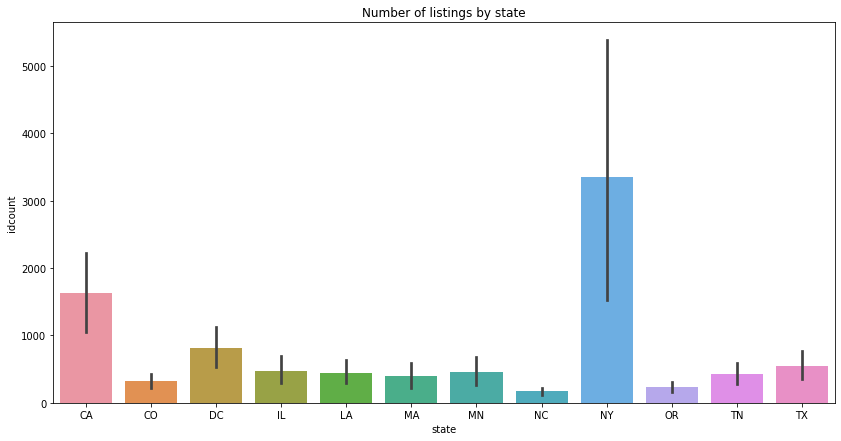

In [14]:
plt.figure(figsize=(14,7))
plt.title('Number of listings by state')
sns.barplot(x='state', y='idcount', data=df_);

As seen in the chart, the number of listed properties by state is not uniform, hence it is necessary to weight the variables based on the number by state

In [15]:
df_.columns

Index(['state', 'quarter', 'property_type', 'price_cleanmedian',
       'price_cleanmean', 'availability_30mean', 'availability_60mean',
       'availability_90mean', 'availability_365mean', 'idcount'],
      dtype='object')

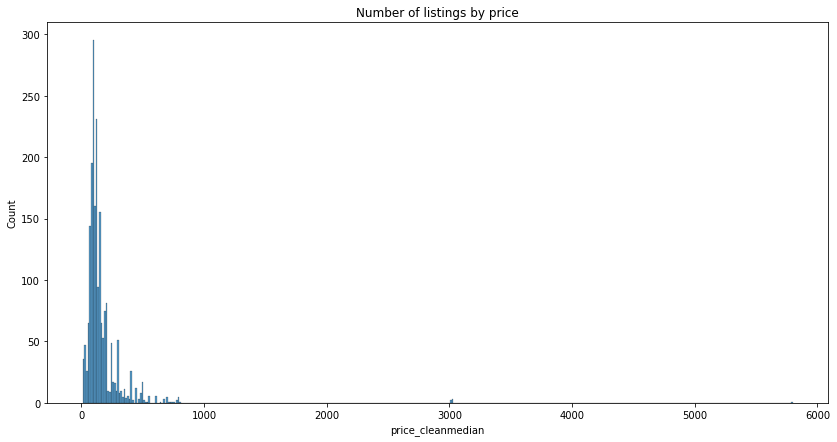

In [16]:
plt.figure(figsize=(14,7))
plt.title('Number of listings by price')
sns.histplot(x='price_cleanmedian', data=df_);

Above chart shows that prices distribution is not a normal one and its right tail is too large (There are very high and isolated prices). Higher prices can be explained for the property types in some states

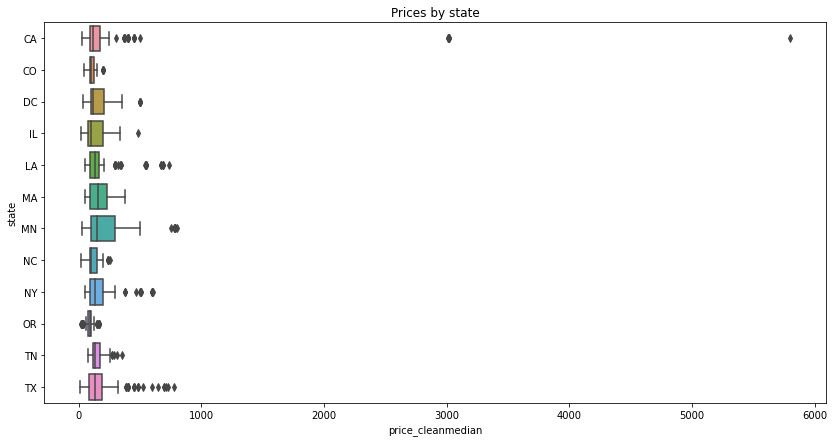

In [17]:
plt.figure(figsize=(14,7))
plt.title('Prices by state')
sns.boxplot(x='price_cleanmedian', y='state', data=df_);

In [18]:
df_[df_['price_cleanmedian'] >= 3000]

,state,quarter,property_type,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean,idcount
15,CA,1Q-2019,Dome house,3022.5,3015.833333,18.166667,38.666667,63.000000,294.500000,6
88,CA,2Q-2018,Dome house,5800.0,5800.000000,30.000000,60.000000,90.000000,365.000000,3
124,CA,2Q-2019,Dome house,3022.5,3022.500000,15.666667,32.666667,48.333333,285.833333,6
198,CA,3Q-2018,Dome house,3012.5,3010.833333,26.166667,54.500000,83.000000,358.000000,6
235,CA,3Q-2019,Dome house,3022.5,3022.500000,16.000000,31.833333,51.500000,253.333333,6
272,CA,4Q-2018,Dome house,3012.5,3009.166667,19.833333,45.500000,74.166667,336.000000,6


The previous chart and tables confirm that prices through the different states have realtively the same median but some states as California have some property types with a high price. They are not necessary wrong data

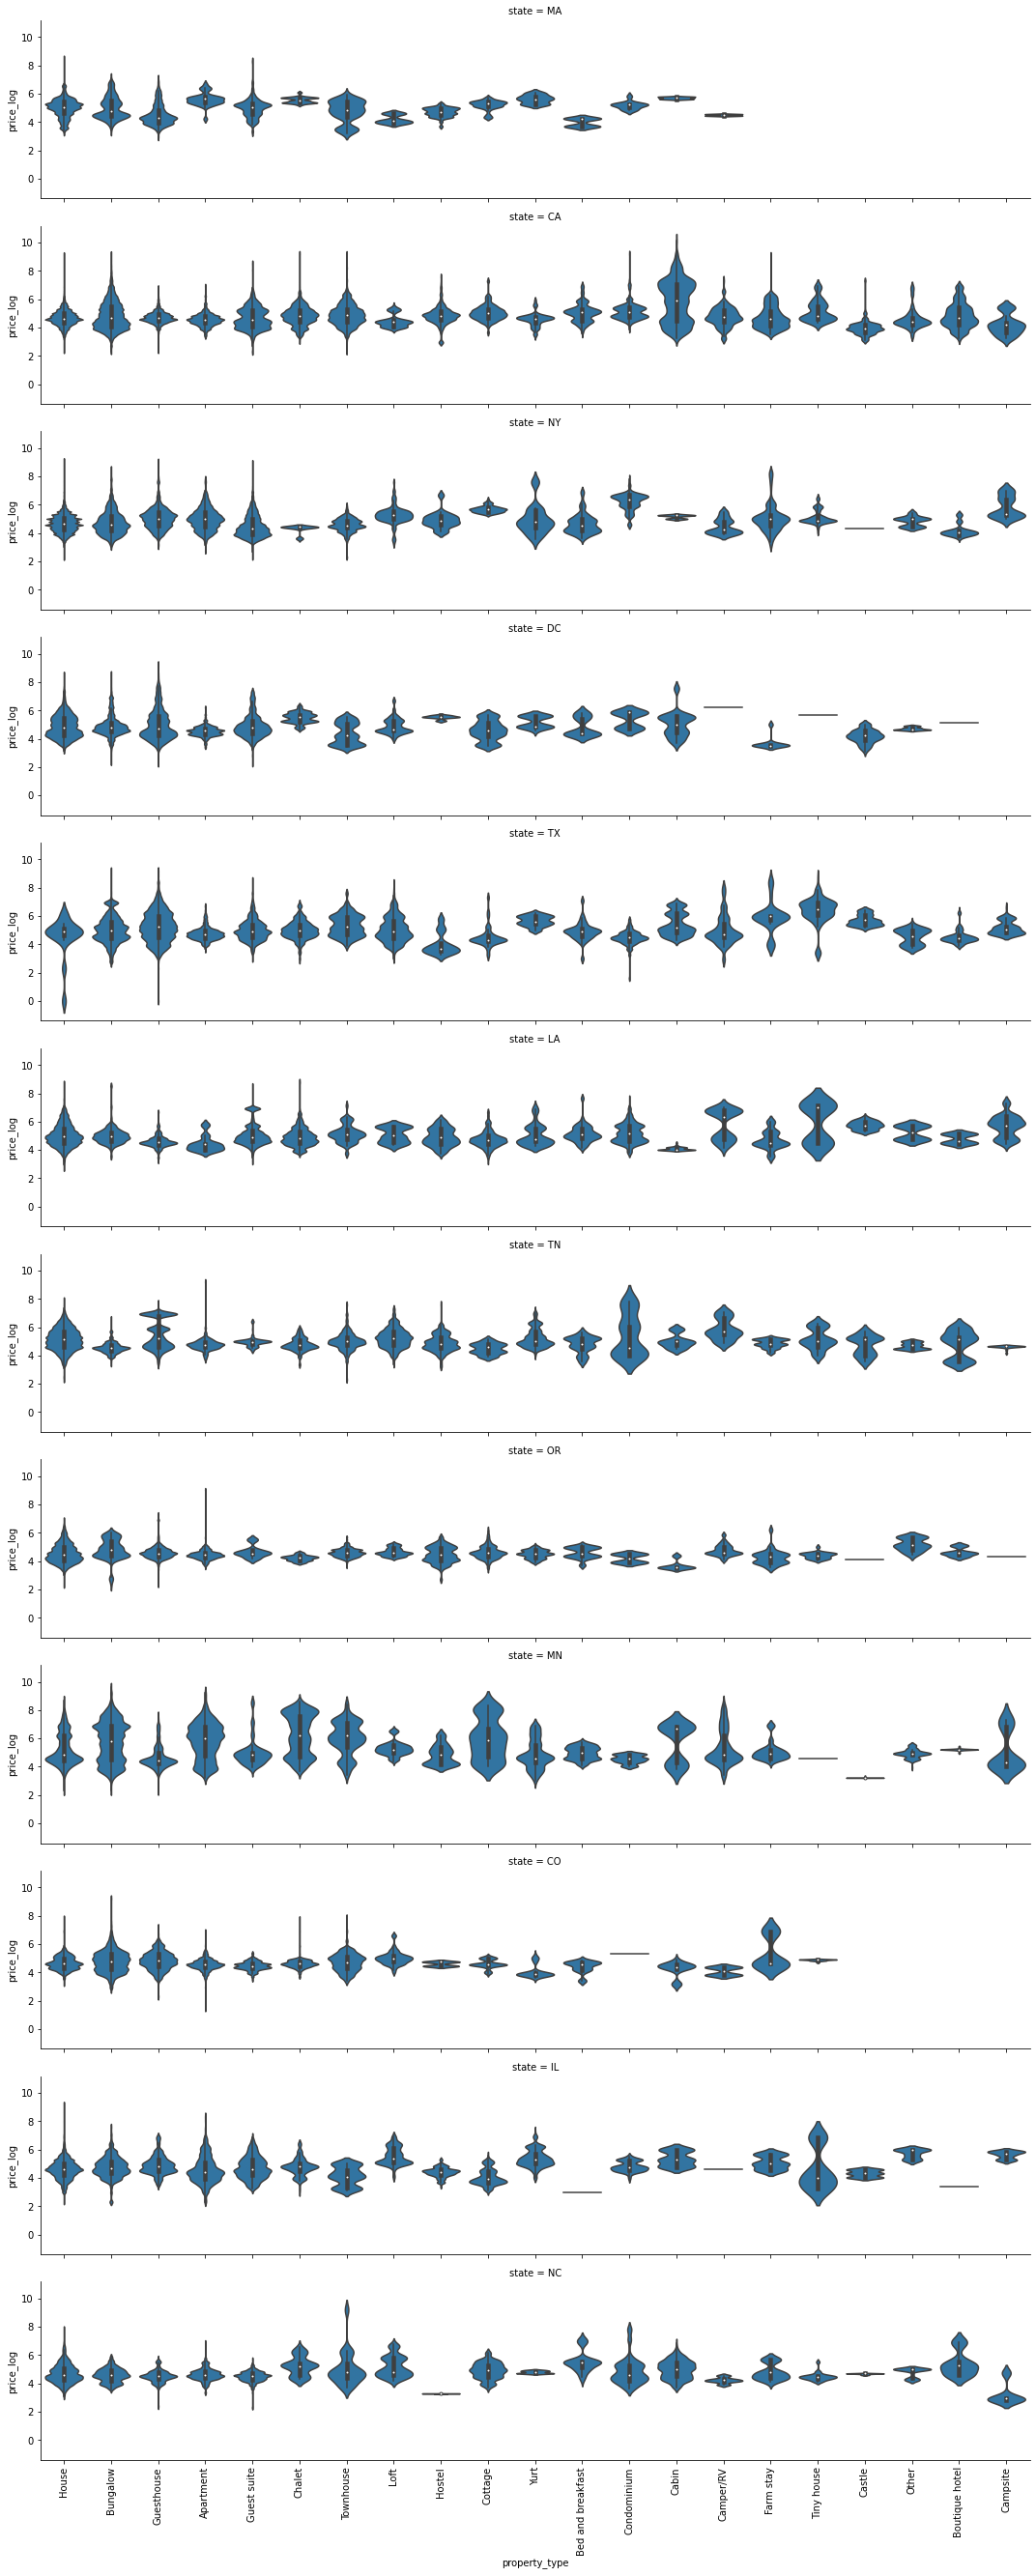

In [19]:
#violin by state
g = sns.FacetGrid(full_df,  row="state",height=3, aspect=5)
g.map_dataframe(sns.violinplot, "property_type", "price_log",scale='width')  
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [20]:
#grouping by property_type and aggregating 
full_df_grouped = full_df.groupby(['state','quarter','property_type']).agg({'price_clean':['median','mean'],'availability_30':['mean'],'availability_60':['mean'],'availability_90':['mean'],'availability_365':['mean'],'id':['count']})

In [21]:
#Cleaning column names
full_df_grouped = full_df_grouped.reset_index()
full_df_grouped.columns = [ ''.join(s).replace(r'[^A-Za-z0-9]+',"_") for s in full_df_grouped.columns]
full_df_grouped.groupby('property_type').sum().sort_values([('idcount')],ascending=False)

,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean,idcount
property_type,,,,,,,
Apartment,13273.5,21331.469632,1073.095110,2523.111409,4178.063019,16027.537331,1073590
House,14291.5,26873.461599,1271.270490,2899.278757,4722.700389,17619.501611,583207
Condominium,17190.5,28961.224233,1105.055518,2550.395164,4196.604867,16712.272519,112196
Townhouse,16060.5,28076.508200,1254.320628,2872.506762,4691.418874,17100.504013,101464
Guest suite,9937.5,11608.239138,1259.647364,3042.284148,5125.187627,17368.764290,77344
Guesthouse,11379.5,15425.867336,1217.588531,2890.467328,4815.157273,18490.126458,61398
Loft,14877.0,23812.265599,1217.667470,2799.908372,4604.483664,18436.273521,46066
Bungalow,11039.5,15969.948342,1212.669167,2793.187982,4633.702534,15757.043164,34221
Serviced apartment,20997.0,23921.099111,1567.591889,3549.886187,5648.096393,21740.361039,14877


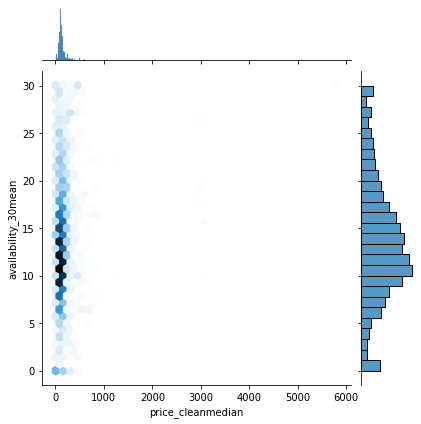

In [22]:
#Distribution and comparison between price and availability
sns.jointplot(data=full_df_grouped, x="price_cleanmedian", y="availability_30mean", kind='hex')
g.fig.set_figwidth(12)
g.fig.set_figheight(10)

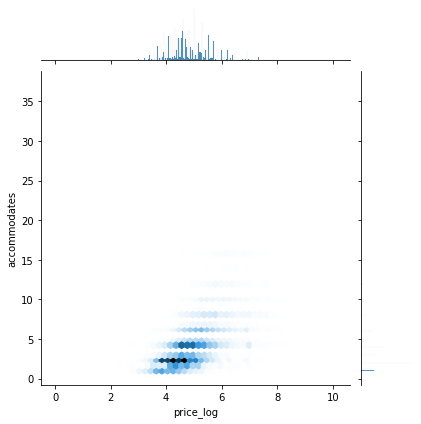

In [23]:
#Distribution and comparison between price and accomodities
sns.jointplot(data=full_df, x="price_log", y="accommodates", kind='hex')
g.fig.set_figwidth(12)
g.fig.set_figheight(10)

In [24]:
#Preparing the dataframe to final columns
full_df_grouped.reset_index(drop=True)

,state,quarter,property_type,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean,idcount
0,CA,1Q-2019,Aparthotel,140.0,147.069892,15.763441,39.876344,63.419355,194.849462,186
1,CA,1Q-2019,Apartment,103.0,136.355256,9.212825,22.588235,37.826760,142.725603,20740
2,CA,1Q-2019,Barn,173.0,173.000000,12.000000,29.666667,56.666667,327.666667,3
3,CA,1Q-2019,Bed and breakfast,100.0,111.071895,23.150327,49.254902,76.150327,306.568627,153
4,CA,1Q-2019,Boat,250.0,562.333333,16.703704,35.888889,55.037037,225.777778,27
...,...,...,...,...,...,...,...,...,...,...
2618,TX,4Q-2019,Tipi,19.0,62.666667,22.555556,50.222222,79.888889,319.555556,9
2619,TX,4Q-2019,Townhouse,140.0,248.682353,8.981699,20.779085,33.400000,119.461438,765
2620,TX,4Q-2019,Treehouse,105.0,112.500000,9.333333,22.166667,37.166667,80.833333,6
2621,TX,4Q-2019,Villa,600.0,778.018868,12.754717,30.415094,50.283019,233.075472,53


In [25]:
#Formatting columns and dates
# This is our final listing dataframe
full_df_grouped['quarter'] = pd.to_datetime(full_df_grouped['quarter'], infer_datetime_format=True) 
full_df_grouped['month'] = pd.DatetimeIndex(full_df_grouped['quarter']).month
full_df_grouped['year'] = pd.DatetimeIndex(full_df_grouped['quarter']).year
full_df_grouped["property_type"] = full_df_grouped["property_type"].astype('category')
full_df_grouped["state"] = full_df_grouped["state"].astype('category')
full_df_grouped['quarter'] = full_df_grouped['quarter'].dt.to_period("Q")
full_df_grouped = full_df_grouped[['state','idcount','month','year','quarter','property_type','price_cleanmedian','price_cleanmean','availability_30mean','availability_60mean','availability_90mean','availability_365mean']]
full_df_grouped = full_df_grouped.sort_values('quarter', ascending=True)

In [26]:
full_df_grouped.dtypes

state                        category
idcount                         int64
month                           int64
year                            int64
quarter                 period[Q-DEC]
property_type                category
price_cleanmedian             float64
price_cleanmean               float64
availability_30mean           float64
availability_60mean           float64
availability_90mean           float64
availability_365mean          float64
dtype: object

In [27]:
#Available states
list(full_df_grouped['state'].unique())

['LA', 'MN', 'CO', 'TN', 'TX', 'NY', 'OR', 'IL', 'DC', 'CA', 'MA', 'NC']

### EDA

In [28]:
#Creating a copy to merge it with economic data
listings_df = full_df_grouped.copy()
listings_df

,state,idcount,month,year,quarter,property_type,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean
921,LA,8,4,2018,2018Q2,Resort,132.5,156.250000,11.375000,21.500000,35.250000,111.875000
1261,MN,86,4,2018,2018Q2,Bungalow,100.0,228.732558,8.976744,21.034884,34.988372,131.802326
1262,MN,60,4,2018,2018Q2,Cabin,175.0,239.566667,17.366667,34.350000,48.866667,236.316667
1263,MN,12,4,2018,2018Q2,Camper/RV,305.0,632.500000,7.750000,17.750000,27.750000,119.416667
1264,MN,9,4,2018,2018Q2,Castle,779.0,536.555556,19.111111,42.444444,67.222222,226.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
1991,OR,1773,4,2020,2020Q2,House,88.0,123.271856,13.403271,29.548787,46.926114,159.650310
1992,OR,6,4,2020,2020Q2,Houseboat,170.0,198.333333,20.166667,41.333333,55.833333,214.166667
1993,OR,2,4,2020,2020Q2,Hut,69.0,69.000000,21.500000,51.500000,81.500000,81.500000
1983,OR,22,4,2020,2020Q2,Camper/RV,73.0,74.363636,18.772727,39.590909,60.909091,192.272727


In [29]:
#Listing cleaning of column names
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2623 entries, 921 to 1541
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   state                 2623 non-null   category     
 1   idcount               2623 non-null   int64        
 2   month                 2623 non-null   int64        
 3   year                  2623 non-null   int64        
 4   quarter               2623 non-null   period[Q-DEC]
 5   property_type         2623 non-null   category     
 6   price_cleanmedian     2623 non-null   float64      
 7   price_cleanmean       2623 non-null   float64      
 8   availability_30mean   2623 non-null   float64      
 9   availability_60mean   2623 non-null   float64      
 10  availability_90mean   2623 non-null   float64      
 11  availability_365mean  2623 non-null   float64      
dtypes: category(2), float64(6), int64(3), period[Q-DEC](1)
memory usage: 232.5 KB


In [30]:
#Get array by state and dates
#get gdp (gdp_states), Unemployment rate (ur_states), and Personal income (pi_states) for the states we want to study

states_of_interest = listings_df.state.unique()

ur_states = ur_dataframe[ur_dataframe['state'].isin(list(states_of_interest))]
ur_states['date']= pd.to_datetime(ur_states['date'])
ur_states = ur_states[['unemployment_rate','state','date']]
ur_states['quarter'] = ur_states['date'].dt.to_period("Q")

gdp_states = gdp_dataframe[gdp_dataframe['state'].isin(list(states_of_interest))]
gdp_states['date']= pd.to_datetime(gdp_states['date'])
gdp_states['date'] = gdp_states['date'].dt.strftime('%Y-%m' + '-01') 
gdp_states['date']= pd.to_datetime(gdp_states['date'])

gdp_states = gdp_states[['gdp','state','date']]

pi_states = pincome_dataframe[pincome_dataframe['state'].isin(list(states_of_interest))]
pi_states['date']= pd.to_datetime(pi_states['date'])
pi_states['date'] = pi_states['date'].dt.strftime('%Y-%m' + '-01') 
pi_states['date']= pd.to_datetime(pi_states['date'])

pi_states = pi_states[['PI','state','date']]

gdp_states

,gdp,state,date
736,1710394.1,CA,2005-01-01
737,1710394.1,CA,2005-02-01
738,1710394.1,CA,2005-03-01
739,1733114.0,CA,2005-04-01
740,1733114.0,CA,2005-05-01
...,...,...,...
8091,1861581.9,TX,2019-12-01
8092,1818394.5,TX,2020-01-01
8093,1818394.5,TX,2020-02-01
8094,1818394.5,TX,2020-03-01


In [31]:
#Aggregating data
ur_states = ur_states.groupby(['state','quarter']).agg({'unemployment_rate':['mean','std']})

ur_states.columns = ['mean_ur','std_ur']
ur_states.reset_index(inplace=True)

gdp_states['quarter'] = gdp_states['date'].dt.to_period("Q")
gdp_states = gdp_states.groupby(['state','quarter']).agg({'gdp':['mean','std']})
gdp_states.columns = ['mean_gdp','std_gdp']
gdp_states.reset_index(inplace=True)

pi_states['quarter'] = pi_states['date'].dt.to_period("Q")
pi_states = pi_states.groupby(['state','quarter']).agg({'PI':['mean','std']})
pi_states.columns = ['mean_pi','std_pi']
pi_states.reset_index(inplace=True)

In [32]:
pi_states

,state,quarter,mean_pi,std_pi
0,CA,2015Q1,2126849.0,0.0
1,CA,2015Q2,2163796.5,0.0
2,CA,2015Q3,2189368.4,0.0
3,CA,2015Q4,2211707.0,0.0
4,CA,2016Q1,2240100.3,0.0
...,...,...,...,...
259,TX,2019Q2,1523340.1,0.0
260,TX,2019Q3,1538237.0,0.0
261,TX,2019Q4,1550113.6,0.0
262,TX,2020Q1,1559485.2,0.0


In [33]:
#Merging all the information
listings_df.set_index(['quarter','state'])

added_unemployment = pd.merge(left=listings_df, right=ur_states, how='left', left_on=['quarter','state'], right_on=['quarter','state'])
added_personal_income = pd.merge(left=added_unemployment, right=pi_states, how='left', left_on=['quarter','state'], right_on=['quarter','state'])
all_merged = pd.merge(left=added_personal_income, right=gdp_states, how='left', left_on=['quarter','state'], right_on=['quarter','state'])
all_merged

,state,idcount,month,year,quarter,property_type,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean,mean_ur,std_ur,mean_pi,std_pi,mean_gdp,std_gdp
0,LA,8,4,2018,2018Q2,Resort,132.5,156.250000,11.375000,21.500000,35.250000,111.875000,5.000000,0.000000,214988.6,0.0,253237.1,0.0
1,MN,86,4,2018,2018Q2,Bungalow,100.0,228.732558,8.976744,21.034884,34.988372,131.802326,2.933333,0.057735,320202.1,0.0,371278.6,0.0
2,MN,60,4,2018,2018Q2,Cabin,175.0,239.566667,17.366667,34.350000,48.866667,236.316667,2.933333,0.057735,320202.1,0.0,371278.6,0.0
3,MN,12,4,2018,2018Q2,Camper/RV,305.0,632.500000,7.750000,17.750000,27.750000,119.416667,2.933333,0.057735,320202.1,0.0,371278.6,0.0
4,MN,9,4,2018,2018Q2,Castle,779.0,536.555556,19.111111,42.444444,67.222222,226.666667,2.933333,0.057735,320202.1,0.0,371278.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,OR,1773,4,2020,2020Q2,House,88.0,123.271856,13.403271,29.548787,46.926114,159.650310,13.600000,1.757840,252884.6,NaN,233799.2,NaN
2619,OR,6,4,2020,2020Q2,Houseboat,170.0,198.333333,20.166667,41.333333,55.833333,214.166667,13.600000,1.757840,252884.6,NaN,233799.2,NaN
2620,OR,2,4,2020,2020Q2,Hut,69.0,69.000000,21.500000,51.500000,81.500000,81.500000,13.600000,1.757840,252884.6,NaN,233799.2,NaN
2621,OR,22,4,2020,2020Q2,Camper/RV,73.0,74.363636,18.772727,39.590909,60.909091,192.272727,13.600000,1.757840,252884.6,NaN,233799.2,NaN


In [34]:
all_merged['quarter'].unique()
all_merged

,state,idcount,month,year,quarter,property_type,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean,mean_ur,std_ur,mean_pi,std_pi,mean_gdp,std_gdp
0,LA,8,4,2018,2018Q2,Resort,132.5,156.250000,11.375000,21.500000,35.250000,111.875000,5.000000,0.000000,214988.6,0.0,253237.1,0.0
1,MN,86,4,2018,2018Q2,Bungalow,100.0,228.732558,8.976744,21.034884,34.988372,131.802326,2.933333,0.057735,320202.1,0.0,371278.6,0.0
2,MN,60,4,2018,2018Q2,Cabin,175.0,239.566667,17.366667,34.350000,48.866667,236.316667,2.933333,0.057735,320202.1,0.0,371278.6,0.0
3,MN,12,4,2018,2018Q2,Camper/RV,305.0,632.500000,7.750000,17.750000,27.750000,119.416667,2.933333,0.057735,320202.1,0.0,371278.6,0.0
4,MN,9,4,2018,2018Q2,Castle,779.0,536.555556,19.111111,42.444444,67.222222,226.666667,2.933333,0.057735,320202.1,0.0,371278.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,OR,1773,4,2020,2020Q2,House,88.0,123.271856,13.403271,29.548787,46.926114,159.650310,13.600000,1.757840,252884.6,NaN,233799.2,NaN
2619,OR,6,4,2020,2020Q2,Houseboat,170.0,198.333333,20.166667,41.333333,55.833333,214.166667,13.600000,1.757840,252884.6,NaN,233799.2,NaN
2620,OR,2,4,2020,2020Q2,Hut,69.0,69.000000,21.500000,51.500000,81.500000,81.500000,13.600000,1.757840,252884.6,NaN,233799.2,NaN
2621,OR,22,4,2020,2020Q2,Camper/RV,73.0,74.363636,18.772727,39.590909,60.909091,192.272727,13.600000,1.757840,252884.6,NaN,233799.2,NaN


### Creating features

In [35]:
#Cleaning
all_merged = all_merged.drop(['std_pi', 'std_gdp'], axis=1)

In [36]:
#Grouping by state and quarter to create weight columns and to get aggregations 
all_merged_filtered_state = all_merged.copy() #[all_merged_for_timeserie['state']=='CO']

df_weighted = all_merged_filtered_state.groupby(['quarter']).apply(lambda g: (g['idcount']*g['price_cleanmedian']).sum()/g['idcount'].sum()).to_frame()
df_weighted.columns = ['price_cleanmedian_W']

df_weighted['availability_30mean_W'] = all_merged_filtered_state.groupby(['quarter']).apply(lambda g: (g['idcount']*g['availability_30mean']).sum()/g['idcount'].sum())
df_weighted['availability_60mean_W'] = all_merged_filtered_state.groupby(['quarter']).apply(lambda g: (g['idcount']*g['availability_60mean']).sum()/g['idcount'].sum())
df_weighted['availability_90mean_W'] = all_merged_filtered_state.groupby(['quarter']).apply(lambda g: (g['idcount']*g['availability_60mean']).sum()/g['idcount'].sum())

df_weighted['unemployment'] = all_merged_filtered_state.groupby(['quarter']).agg({'mean_ur':['mean']})
df_weighted['income'] = all_merged_filtered_state.groupby(['quarter']).agg({'mean_pi':['mean']})
df_weighted['gdp'] = all_merged_filtered_state.groupby(['quarter']).agg({'mean_gdp':['mean']})
df_weighted['count'] = all_merged_filtered_state.groupby(['quarter']).agg({'idcount':['sum']})

df_weighted

,price_cleanmedian_W,availability_30mean_W,availability_60mean_W,availability_90mean_W,unemployment,income,gdp,count
quarter,,,,,,,,
2018Q2,125.476700,7.966841,18.946152,18.946152,4.041053,818971.128772,9.889207e+05,182664
2018Q3,127.180009,8.355710,20.466804,20.466804,3.946233,835582.126370,1.004813e+06,241804
2018Q4,126.041599,9.754304,23.763345,23.763345,3.969056,842829.115358,1.012420e+06,254742
2019Q1,125.665988,10.319553,23.147279,23.147279,3.975882,854634.932082,1.022188e+06,255413
2019Q2,127.251872,7.925465,18.918953,18.918953,3.843800,861353.726621,1.034633e+06,255666
2019Q3,126.481681,7.910868,19.430904,19.430904,3.752105,866422.428328,1.043284e+06,252715
2019Q4,125.631194,8.914930,21.533267,21.533267,3.726280,875307.355973,1.055444e+06,254413
2020Q1,125.875704,10.610353,23.022329,23.022329,3.946804,885503.514384,1.047489e+06,246138
2020Q2,127.424799,11.442425,24.394818,24.394818,12.906920,953649.440484,9.512374e+05,227505


In [37]:
df_weighted.head(50)

,price_cleanmedian_W,availability_30mean_W,availability_60mean_W,availability_90mean_W,unemployment,income,gdp,count
quarter,,,,,,,,
2018Q2,125.476700,7.966841,18.946152,18.946152,4.041053,818971.128772,9.889207e+05,182664
2018Q3,127.180009,8.355710,20.466804,20.466804,3.946233,835582.126370,1.004813e+06,241804
2018Q4,126.041599,9.754304,23.763345,23.763345,3.969056,842829.115358,1.012420e+06,254742
2019Q1,125.665988,10.319553,23.147279,23.147279,3.975882,854634.932082,1.022188e+06,255413
2019Q2,127.251872,7.925465,18.918953,18.918953,3.843800,861353.726621,1.034633e+06,255666
2019Q3,126.481681,7.910868,19.430904,19.430904,3.752105,866422.428328,1.043284e+06,252715
2019Q4,125.631194,8.914930,21.533267,21.533267,3.726280,875307.355973,1.055444e+06,254413
2020Q1,125.875704,10.610353,23.022329,23.022329,3.946804,885503.514384,1.047489e+06,246138
2020Q2,127.424799,11.442425,24.394818,24.394818,12.906920,953649.440484,9.512374e+05,227505


In [38]:
#Grouping data by quarter and state
#Creating columns with weighted data
merged_copy = all_merged.copy()

data_weighted = merged_copy.groupby(['quarter', 'state']).apply(lambda g: (g['idcount']*g['price_cleanmedian']).sum()/g['idcount'].sum()).to_frame()
data_weighted.columns = ['price_cleanmedian_W']

data_weighted['availability_30mean_W'] = merged_copy.groupby(['quarter', 'state']).apply(lambda g: (g['idcount']*g['availability_30mean']).sum()/g['idcount'].sum())
data_weighted['availability_60mean_W'] = merged_copy.groupby(['quarter', 'state']).apply(lambda g: (g['idcount']*g['availability_60mean']).sum()/g['idcount'].sum())
data_weighted['availability_90mean_W'] = merged_copy.groupby(['quarter', 'state']).apply(lambda g: (g['idcount']*g['availability_60mean']).sum()/g['idcount'].sum())

data_weighted['unemployment'] = merged_copy.groupby(['quarter', 'state']).agg({'mean_ur':['mean']})
data_weighted['income'] = merged_copy.groupby(['quarter', 'state']).agg({'mean_pi':['mean']})
data_weighted['gdp'] = merged_copy.groupby(['quarter', 'state']).agg({'mean_gdp':['mean']})
data_weighted['count'] = merged_copy.groupby(['quarter', 'state']).agg({'idcount':['sum']})

data_weighted



price_cleanmedian_W  availability_30mean_W  \
quarter state                                               
2018Q2  CA              109.850066              10.613081   
        CO              107.583909              10.002514   
        DC              121.541098               6.825788   
        IL              102.483753              10.618766   
        LA              141.288080              12.162814   
...                            ...                    ...   
2020Q2  NC              103.533024              10.210506   
        NY              104.245303               9.125906   
        OR               90.125612              14.787751   
        TN              169.389035              16.422667   
        TX              164.832350               8.892711   

               availability_60mean_W  availability_90mean_W  unemployment  \
quarter state                                                               
2018Q2  CA                 24.715921              24.715921      4.266667   
        CO                 22.318668              22.318668      3.133333   
        DC                 16.426102              16.426102      5.733333   
        IL                 24.460817              24.460817      4.300000   
        LA                 30.879488              30.879488      5.000000   
...                              ...                    ...           ...   
2020Q2  NC                 25.307455              25.307455     11.066667   
        NY                 19.019378              19.019378     15.133333   
        OR                 32.213140              32.213140     13.600000   
        TN                 33.664523              33.664523     12.033333   
        TX                 19.705165              19.705165     11.633333   

                  income        gdp  count  
quarter state                               
2018Q2  CA     2500871.9  2966250.1  51556  
        CO      332573.6   371053.9   1591  
        DC       56669.1   138232.6  10183  
        IL      724439.5   860142.0   5755  
        LA      214988.6   253237.1   6099  
...                  ...        ...    ...  
2020Q2  NC      540565.9   546775.7   2589  
        NY     1493369.3  1587879.2  79575  
        OR      252884.6   233799.2   4490  
        TN      352529.0   333194.3   9485  
        TX     1678239.6  1628185.0  17793  

[108 rows x 8 columns]

In [39]:
#Calculating variation percentage per variable (Dataframe for results)
variation_data = data_weighted.groupby(level=1).apply(lambda g: g.pct_change())
variation_data = variation_data[~variation_data.isna().any(axis=1)]
variation_data = variation_data.drop(variation_data.tail(24).index)
variation_data.head(50)

price_cleanmedian_W  availability_30mean_W  \
quarter state                                               
2018Q3  CA                0.022426              -0.048067   
        CO                0.029354              -0.176492   
        DC               -0.020965               0.289554   
        IL                0.013255              -0.053793   
        LA               -0.031256               0.396196   
        MA               -0.018931              -0.251977   
        MN               -0.134556              -0.107696   
        NC               -0.025587              -0.117611   
        NY                0.005710               0.012764   
        OR                0.024484              -0.223575   
        TN               -0.057398               0.055429   
        TX               -0.028478               0.102203   
2018Q4  CA               -0.023081               0.184068   
        CO               -0.005348               0.456141   
        DC               -0.017650               0.103837   
        IL               -0.007244               0.455746   
        LA                0.017284              -0.209556   
        MA               -0.004625               0.470661   
        MN               -0.089577               0.190284   
        NC                0.007285               0.116390   
        NY                0.042734               0.123754   
        OR               -0.004037               0.582949   
        TN                0.011148               0.328618   
        TX               -0.018085               0.052018   
2019Q1  CA                0.000842              -0.064373   
        CO               -0.006855              -0.106607   
        DC               -0.001190              -0.055315   
        IL               -0.020066               0.068571   
        LA                0.015717              -0.127263   
        MA                0.001686              -0.010585   
        MN                0.021967               0.106199   
        NC                0.007764               0.152526   
        NY               -0.011995               0.500465   
        OR               -0.013387               0.030167   
        TN               -0.025166              -0.082191   
        TX               -0.001231              -0.119208   
2019Q2  CA                0.020470              -0.109428   
        CO                0.001991              -0.431230   
        DC                0.000606              -0.300537   
        IL                0.009366              -0.330513   
        LA               -0.006508               0.155451   
        MA                0.068086              -0.246634   
        MN               -0.003607              -0.165727   
        NC               -0.001286              -0.242884   
        NY                0.012049              -0.441909   
        OR                0.003580              -0.285749   
        TN                0.022982              -0.148190   
        TX                0.017824              -0.044662   
2019Q3  CA                0.000129              -0.062336   
        CO                0.016546               0.027040   

               availability_60mean_W  availability_90mean_W  unemployment  \
quarter state                                                               
2018Q3  CA                  0.036600               0.036600     -0.015625   
        CO                  0.001815               0.001815      0.031915   
        DC                  0.272888               0.272888     -0.017442   
        IL                  0.075540               0.075540     -0.007752   
        LA                  0.177657               0.177657     -0.013333   
        MA                 -0.138359              -0.138359     -0.038835   
        MN                 -0.032580              -0.032580     -0.034091   
        NC                 -0.070151              -0.070151     -0.016807   
        NY                  0.007120               0.007120     -0.06349

In [40]:
variation_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72 entries, (Period('2018Q3', 'Q-DEC'), 'CA') to (Period('2019Q4', 'Q-DEC'), 'TX')
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_cleanmedian_W    72 non-null     float64
 1   availability_30mean_W  72 non-null     float64
 2   availability_60mean_W  72 non-null     float64
 3   availability_90mean_W  72 non-null     float64
 4   unemployment           72 non-null     float64
 5   income                 72 non-null     float64
 6   gdp                    72 non-null     float64
 7   count                  72 non-null     float64
dtypes: float64(8)
memory usage: 5.5+ KB


In [41]:
#Grouping by state to plot it
full_by_state_df = full_df_grouped.groupby('state').mean()
full_by_state_df

,idcount,month,year,price_cleanmedian,price_cleanmean,availability_30mean,availability_60mean,availability_90mean,availability_365mean
state,,,,,,,,,
CA,1602.631420,5.341390,2018.894260,227.135952,295.830309,15.305802,34.775327,56.120089,208.524095
CO,313.236842,5.361842,2018.881579,105.519737,133.796296,10.955615,25.981650,43.095739,155.689455
DC,820.418994,5.340782,2018.882682,161.581006,196.903059,13.970287,31.431054,50.815140,193.213914
IL,477.989744,5.338462,2018.892308,132.505128,165.280065,12.582139,28.140464,45.184174,174.427786
LA,453.681159,5.333333,2018.888889,189.171498,221.819560,15.411372,33.775376,53.966175,190.579748
MA,392.170370,5.333333,2018.888889,161.277778,180.792218,10.334164,23.835274,39.036612,158.759248
MN,460.702703,5.343629,2018.888031,218.194981,357.426725,12.655511,28.351114,45.329991,154.771130
NC,167.212766,5.340426,2018.893617,116.821809,170.827046,14.837899,33.401080,54.388620,214.021177
NY,3333.325893,5.339286,2018.892857,169.102679,215.234679,13.918720,31.434175,50.631946,179.453866


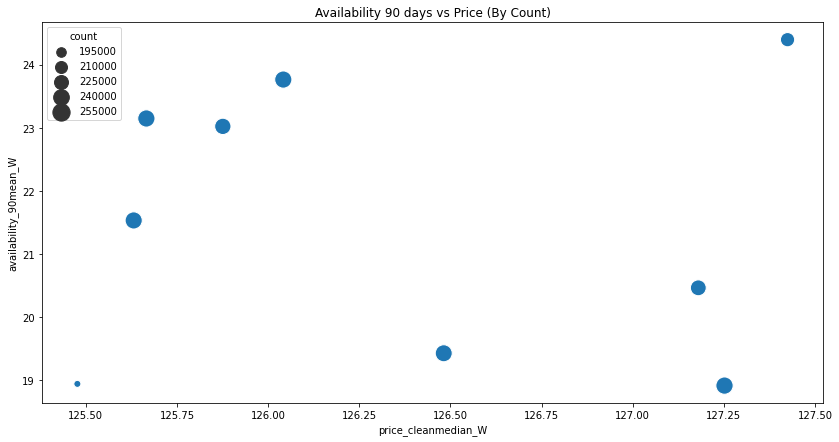

In [42]:
plt.figure(figsize=(14,7))
plt.title('Availability 90 days vs Price (By Count)')
sns.scatterplot(data = df_weighted, x = 'price_cleanmedian_W', y = 'availability_90mean_W', size = 'count',  sizes=(50, 300));

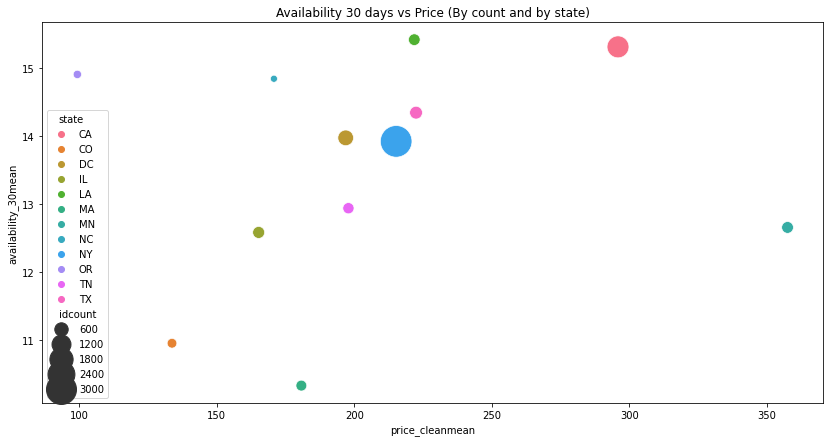

In [43]:
plt.figure(figsize=(14,7))
plt.title('Availability 30 days vs Price (By count and by state)')
sns.scatterplot(data = full_by_state_df, x = 'price_cleanmean', y = 'availability_30mean', hue = 'state', size = 'idcount',  sizes=(50, 1000));

LA


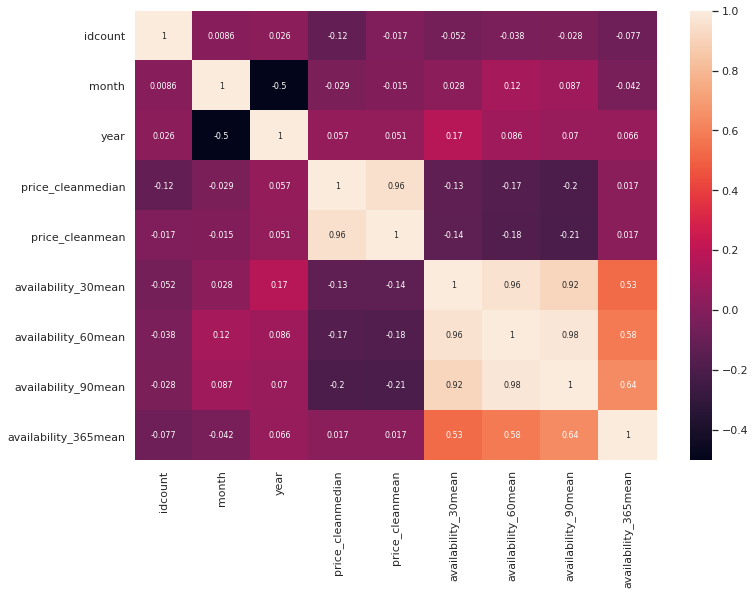

MN


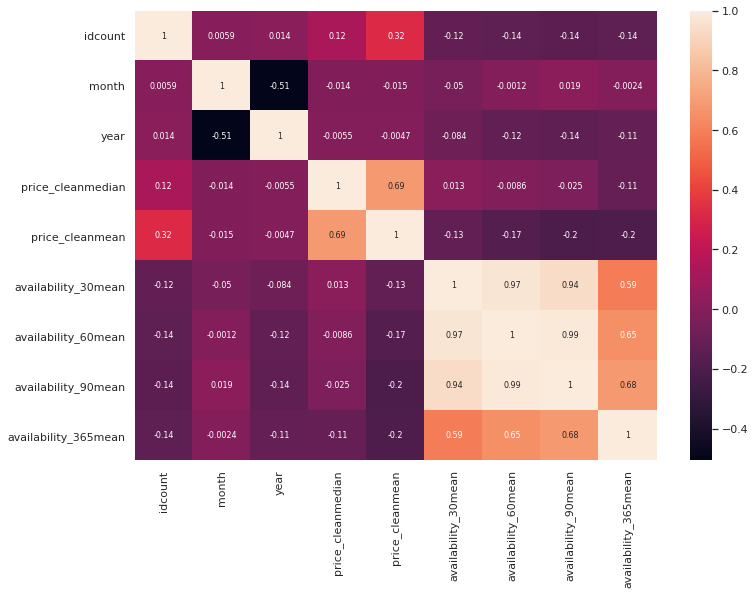

CO


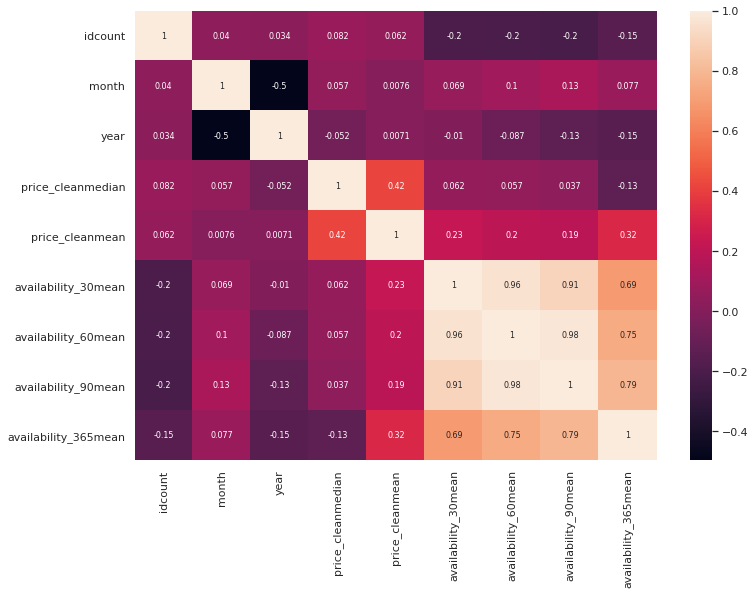

TN


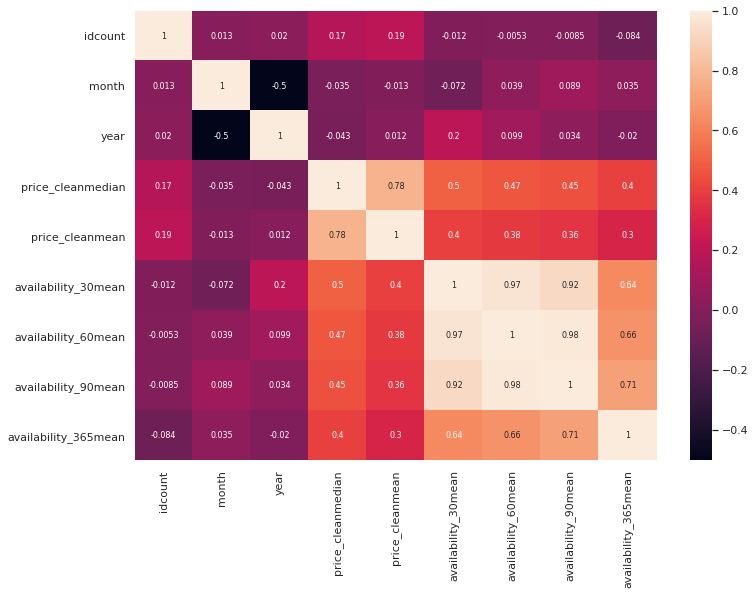

TX


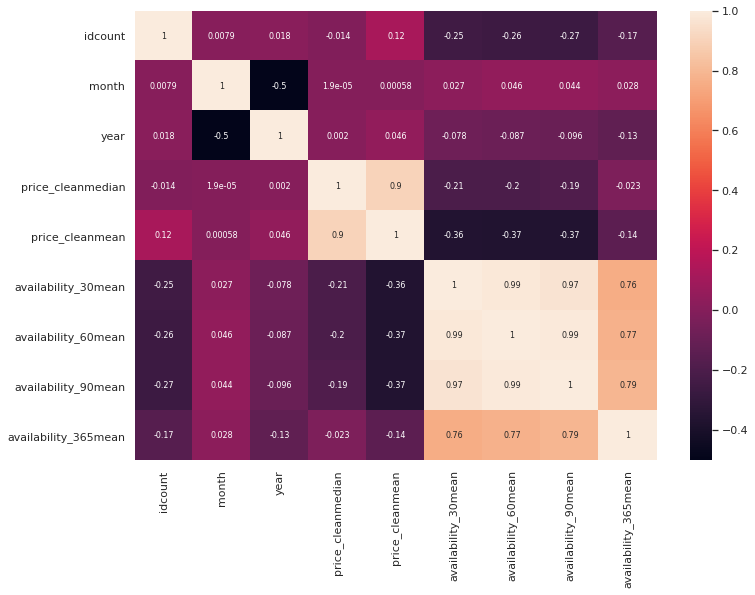

NY


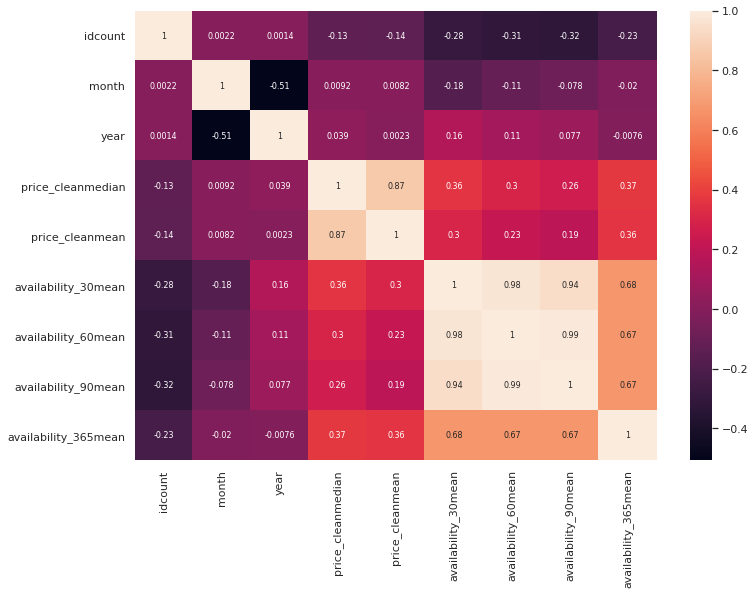

OR


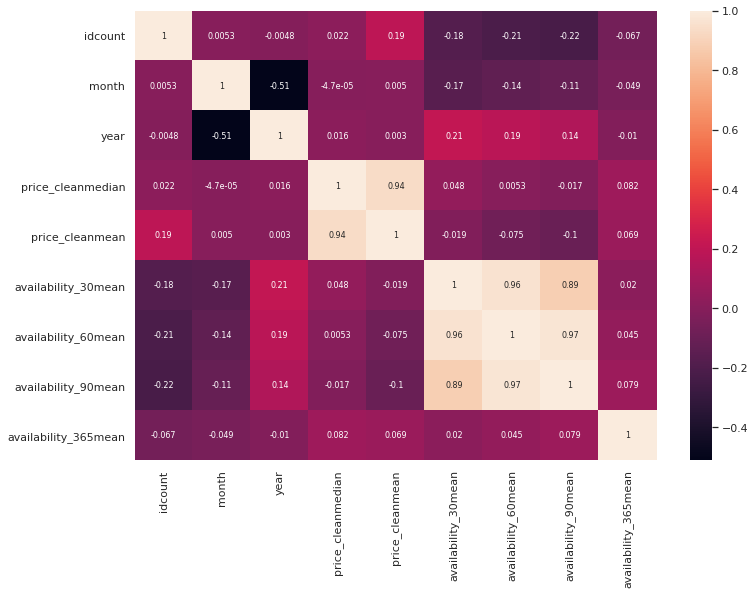

IL


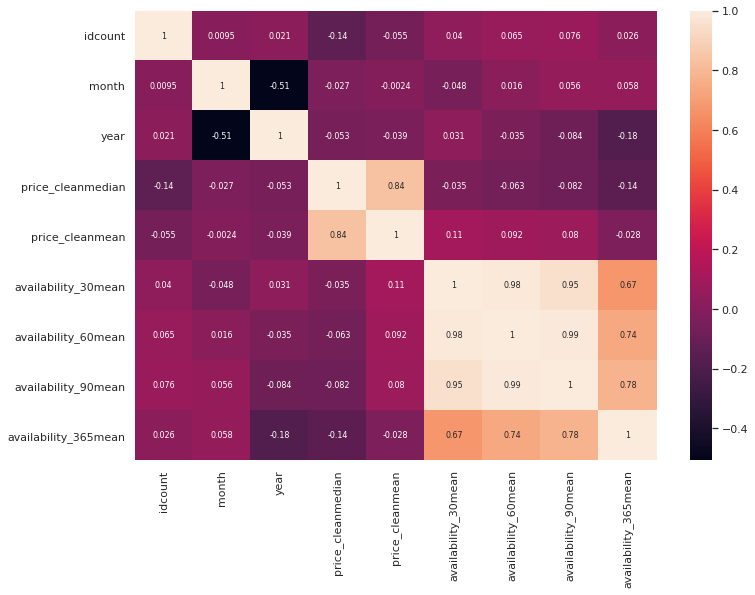

DC


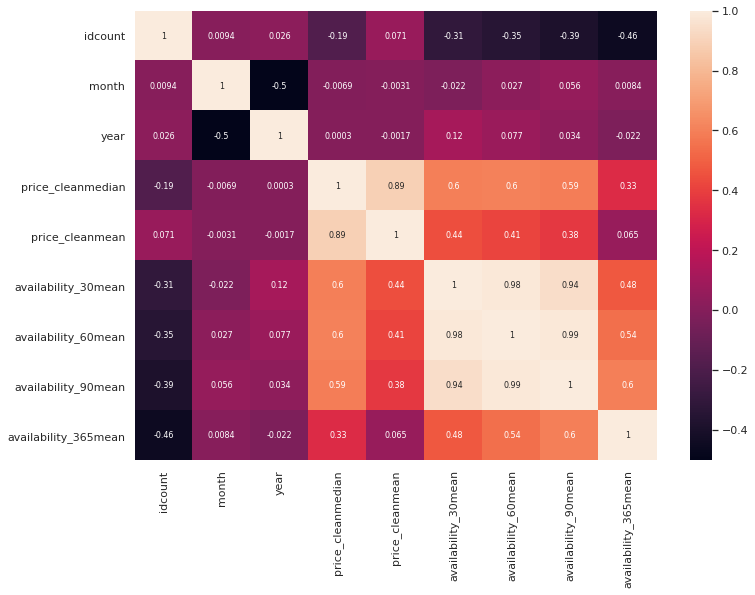

CA


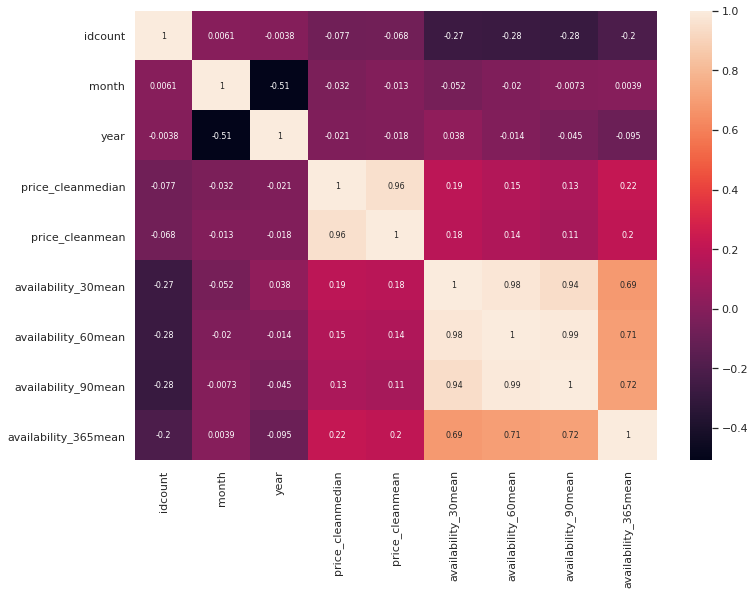

MA


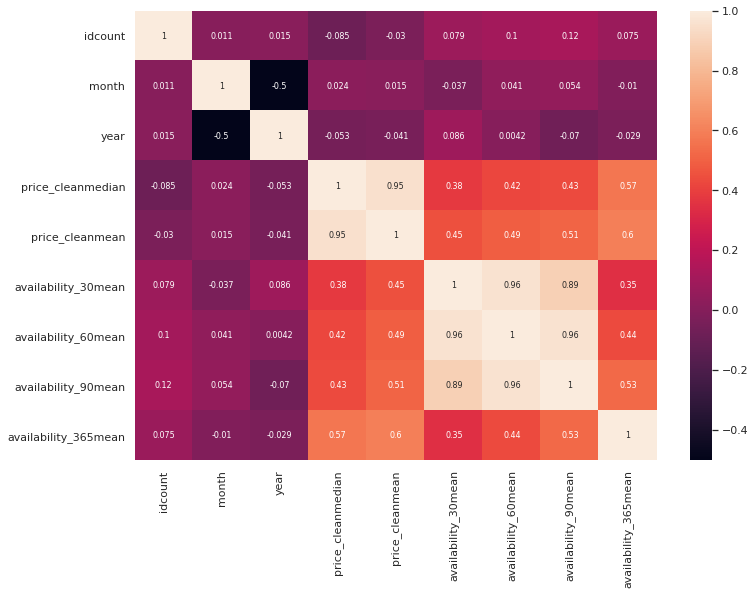

NC


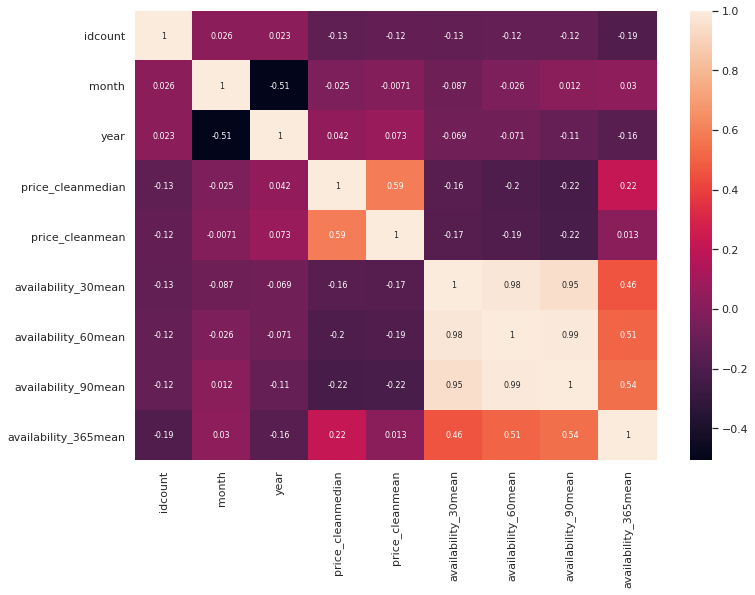

In [44]:
#Verifying correlations by state
for state in states_of_interest :
    all_merged_ST = full_df_grouped[full_df_grouped['state'] == state]
    corrMatrix = all_merged_ST.corr()
    sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":8})
    print(state)
    sns.heatmap(corrMatrix, annot=True)
    plt.show()

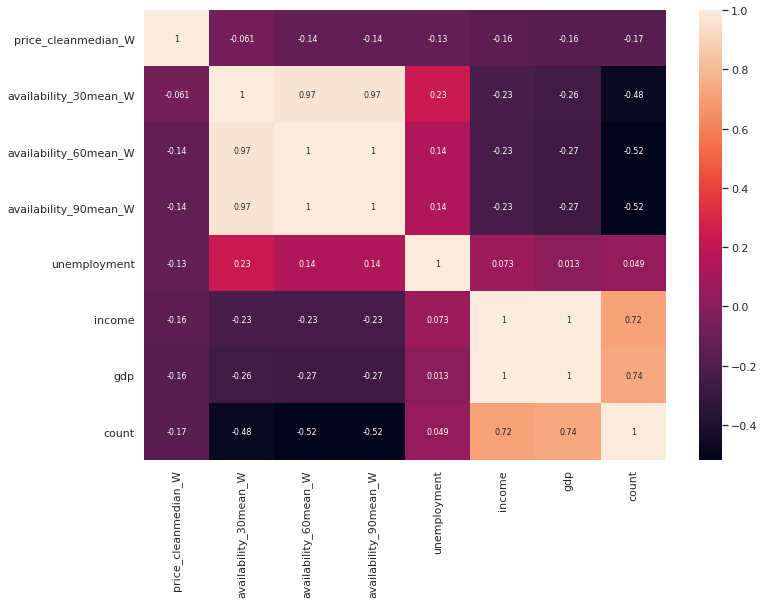

In [45]:
#Verifying correlations for the entire data
corrMatrix = data_weighted.corr()

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":8})
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Linear regression- results

In [46]:
#Calculating linear regression for variables (% variation)
model = 'count ~ gdp + unemployment + income'
linear = sm2.ols(formula = model, data = variation_data).fit()
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5.101
Date:                Sat, 19 Dec 2020   Prob (F-statistic):            0.00304
Time:                        14:13:58   Log-Likelihood:                -43.263
No. Observations:                  72   AIC:                             94.53
Df Residuals:                      68   BIC:                             103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0551      0.134      0.411   

###### In-sample predict

In [47]:
ypred = linear.predict(variation_data[['gdp','unemployment','income']])

###### Creating a new random sample of explanatory variables, predict and plot

In [48]:
#Creating a random parameters dataset and calculating the result of the model
sample_gdp = pd.DataFrame(stats.uniform(variation_data['gdp'].quantile(.1), variation_data['gdp'].quantile(.9)).rvs(48), columns = ['gdp'])
sample_income = pd.DataFrame(stats.uniform(variation_data['income'].quantile(.1), variation_data['income'].quantile(.9)).rvs(48), columns = ['income'])
sample_unemployment = pd.DataFrame(stats.uniform(variation_data['unemployment'].quantile(.1),variation_data['unemployment'].quantile(.9)).rvs(48), columns = ['unemployment'])
sample_econ = pd.concat([sample_gdp, sample_unemployment, sample_income], axis = 1)
ynewpred =  linear.predict(sample_econ) 

In [49]:
sample_econ

,gdp,unemployment,income
0,0.006984,-0.034841,0.017022
1,0.008396,-0.039661,0.005674
2,0.013314,-0.033768,0.009803
3,0.006347,-0.025982,0.008083
4,0.015372,-0.030807,0.008490
5,0.006772,-0.033766,0.014099
6,0.005949,-0.047687,0.014608
7,0.011397,-0.044127,0.015665
8,0.011459,-0.026150,0.014216
9,0.005726,-0.036666,0.006824


###### Plotting

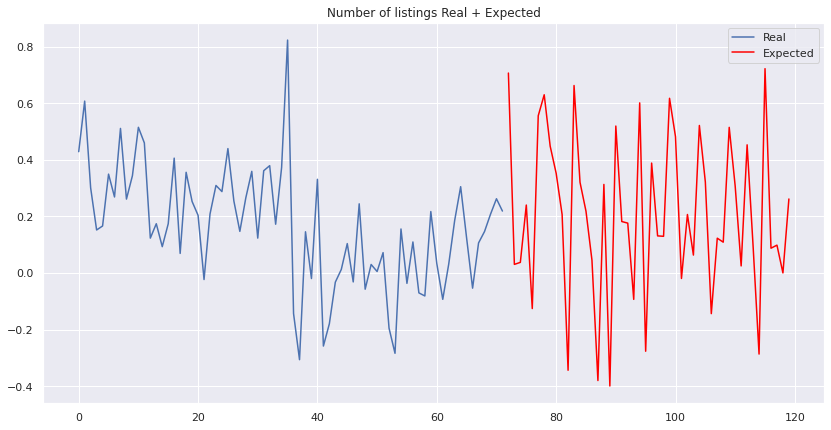

In [50]:
#Plotting real results and expected results based on random parameters
plt.figure(figsize = (14,7))
plt.title('Number of listings Real + Expected')
plt.plot(list(range(72)), list(ypred), label='AAA')
plt.plot(list(range(72,120)), list(ynewpred), color = 'red')
plt.legend(['Real', 'Expected'])
plt.show()


In [51]:
#Random parameter values + expected result
sample_econ['Expected number of listings'] = list(ynewpred)
sample_econ

,gdp,unemployment,income,Expected number of listings
0,0.006984,-0.034841,0.017022,0.706437
1,0.008396,-0.039661,0.005674,0.030667
2,0.013314,-0.033768,0.009803,0.037743
3,0.006347,-0.025982,0.008083,0.240226
4,0.015372,-0.030807,0.008490,-0.125361
5,0.006772,-0.033766,0.014099,0.555575
6,0.005949,-0.047687,0.014608,0.629757
7,0.011397,-0.044127,0.015665,0.448254
8,0.011459,-0.026150,0.014216,0.352781
9,0.005726,-0.036666,0.006824,0.206856


###### Prediction

In [52]:
#Calculating expected number of listings percentage variation based on economic parameters
gdp_input=input(prompt='Type in a GDP % change value[-1,1]:')
unemployment_input=input(prompt='Type in an unemployment % change value[-1,1]:')
income_input=input(prompt='Type in a personal income % changhe value[-1,1]:')
if (gdp_input.isnumeric and float(gdp_input) < 1 and float(gdp_input) > -1) or \
    (unemployment_input.isnumeric and float(unemployment_input) < 1 and float(unemployment_input) > -1) or \
    (income_input.isnumeric and float(income_input) < 1 and float(income_input) > -1):
    parameters = pd.DataFrame(np.array([[float(gdp_input), float(unemployment_input), float(income_input)]]),
                   columns=['gdp', 'unemployment', 'income'])
    regression_result =  linear.predict(parameters) 
    print('----------------------------------------------------')
    print('Predicted value for variation in number of listings:')
    print(str(round(regression_result[0],3)) + '%')
else :
    print('Values must be numeric, greater than -1 and less than 1')

Type in a GDP % change value[-1,1]:0.001
Type in an unemployment % change value[-1,1]:0.001
Type in a personal income % changhe value[-1,1]:0.001
----------------------------------------------------
Predicted value for variation in number of listings:
0.065%
